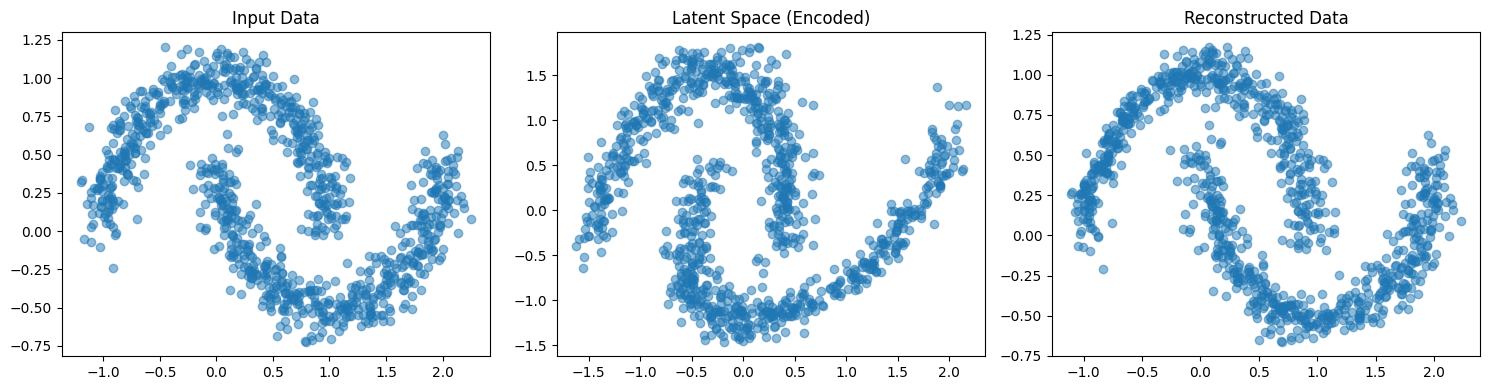

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Generate toy dataset
X, _ = make_moons(n_samples=1000, noise=0.1)
X = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )
    def forward(self, x):
        return self.fc(x)

# Define Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )
    def forward(self, z):
        return self.fc(z)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.fc(z)

# Initialize models
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()

# Optimizers
ae_optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)
g_optimizer = optim.Adam(encoder.parameters(), lr=1e-3)

# Loss
recon_loss = nn.MSELoss()
bce_loss = nn.BCELoss()

# Training loop (short for demo)
for epoch in range(100):
    for batch in loader:
        x = batch[0]

        # ------------------
        # Reconstruction
        # ------------------
        z = encoder(x)
        x_hat = decoder(z)
        loss_recon = recon_loss(x_hat, x)
        ae_optimizer.zero_grad()
        loss_recon.backward()
        ae_optimizer.step()

        # ------------------
        # Discriminator
        # ------------------
        z_real = torch.randn_like(z)
        d_real = discriminator(z_real)
        d_fake = discriminator(z.detach())
        real_labels = torch.ones_like(d_real)
        fake_labels = torch.zeros_like(d_fake)
        loss_d = bce_loss(d_real, real_labels) + bce_loss(d_fake, fake_labels)
        d_optimizer.zero_grad()
        loss_d.backward()
        d_optimizer.step()

        # ------------------
        # Generator (Encoder)
        # ------------------
        z = encoder(x)
        d_fake = discriminator(z)
        loss_g = bce_loss(d_fake, real_labels)
        g_optimizer.zero_grad()
        loss_g.backward()
        g_optimizer.step()

def visualize(encoder, decoder, X):
    with torch.no_grad():
        z = encoder(X)
        X_hat = decoder(z).numpy()
        z = z.numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].scatter(X[:, 0], X[:, 1], alpha=0.5)
    axs[0].set_title("Input Data")

    axs[1].scatter(z[:, 0], z[:, 1], alpha=0.5)
    axs[1].set_title("Latent Space (Encoded)")

    axs[2].scatter(X_hat[:, 0], X_hat[:, 1], alpha=0.5)
    axs[2].set_title("Reconstructed Data")

    plt.tight_layout()
    plt.show()

visualize(encoder, decoder, X)